# Simulated Annealing TSP

In [1]:
import pandas as pd

In [2]:
def load_nodes(path):
    df=pd.read_csv(path)
    df.rename({'X':'lon','Y':'lat'},axis='columns',inplace=True)
    return df

def load_data(path):
    df=pd.read_csv(path, encoding = 'utf-8',dtype={'InputID':'string','TargetID':'string','Distance':float}) 
    df['InputID'] = df['InputID'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    df['TargetID'] = df['TargetID'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    #df['TargetID']=df['TargetID'].astype('category')
    #df['InputID']=df['InputID'].astype('category')
    return df

In [4]:
dist_path='data/distancias_maule.csv'
edge_data=load_data(dist_path)
nodes_path='data/comunas_maule.csv'
node_data=load_nodes(nodes_path)

In [5]:
node_data.head()

,lon,lat,Z,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia
0,-71.953081,-35.129891,0,279,191493.545385,17,9,7103,7,1.602501e+09,234347.693056,Región del Maule,Curepto,Talca
1,-72.284260,-35.613610,0,280,142724.349430,17,9,7104,7,8.575285e+08,175634.266010,Región del Maule,Empedrado,Talca
2,-71.816301,-35.327665,0,283,176274.410596,17,9,7107,7,1.437081e+09,216188.830744,Región del Maule,Pencahue,Talca
3,-71.331995,-35.958516,0,271,288033.759891,18,9,7401,7,2.245999e+09,356106.042176,Región del Maule,Linares,Linares
4,-71.441142,-36.110871,0,272,267604.712137,18,9,7403,7,2.231920e+09,331498.941045,Región del Maule,Longaví,Linares


In [6]:
edge_data.iloc[1]

InputID     Curepto
TargetID      Rauco
Distance    52563.8
Name: 1, dtype: object

In [7]:
import numpy as np
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r *1000

In [8]:
get_lon_lat = lambda comuna : node_data[node_data['Comuna']==comuna][['lon','lat']].values[0]

In [9]:
p1=get_lon_lat('Curepto')
p2=get_lon_lat('Rauco')

In [10]:
haversine(p1[0], p1[1], p2[0], p2[1])

52485.88162076175

In [11]:
import numpy as np
from heapq import heappush,heappop

class abstract_graph:
    
    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={u for u,v in self.edges} | {v for u,v in self.edges}
        
    def adjacency_matrix(self):
        pass
    
    def adjacency_list(self):
        pass

    
class simple_graph(abstract_graph):
    
    def adjacency_list(self):
        adjacent=lambda n : {v for u,v in self.edges if u==n } | {u for u,v in self.edges if v==n}
        return {v:adjacent(v) for v in self.nodes}
    

    
class weighted_graph(abstract_graph):
    
    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={u for u,v in self.edges.keys()} | {v for u,v in self.edges.keys()}
        
    def adjacency_matrix(self):
        n=len(self.nodes)
        mat=np.zeros((n,n))
        adjacent=lambda x : [1 if x==v else 0 for (u,v) in enumerate(sorted(list(G.nodes))) ]
        L=self.adjacency_list()
        i=0
        for v in sorted(list(G.nodes)):
            for l in L[v]:
                mat[i,]+=adjacent(l)
            i=i+1
        return mat
    
    def adjacency_list(self):
        adjacent=lambda n : {v for u,v in self.edges.keys() if u==n } | {u for u,v in self.edges if v==n}
        return {v:adjacent(v) for v in self.nodes}

class weighted_digraph(abstract_graph):
    
    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={u for u,v in self.edges.keys()} | {v for u,v in self.edges.keys()}
        
    
    def adjacency_list(self):
        adjacent=lambda n : {v for u,v in self.edges.keys() if u==n } 
        return {v:adjacent(v) for v in self.nodes}

In [12]:
import heapq

def prim_mst(graph,start):
    pq, path = [], []
    tree=[]
    heappush(pq, (0, start))
    adjacency=graph.adjacency_list()
    while pq:
        i,vertex=heappop(pq)
        if vertex in path:
            continue
        print('Vertice : {0}, Prioridad {1}'.format(vertex,i))
        path.append(vertex)
        for neighbor in adjacency[vertex]:
            if neighbor not in path:
                if (vertex,neighbor) in graph.edges:
                    heappush(pq, (graph.edges[(vertex,neighbor)], neighbor))
                    tree.append((vertex,neighbor))
                else:
                    heappush(pq, (graph.edges[(neighbor,vertex)], neighbor))
                    tree.append((neighbor,vertex))
    return tree

In [13]:
E={}
for index, row in edge_data.iterrows():
    E.update({(str(row['InputID']), str(row['TargetID'])):row['Distance']/1000})


In [14]:
G=weighted_graph(E)

In [15]:
T=prim_mst(G,'Talca')

Vertice : Talca, Prioridad 0
Vertice : Maule, Prioridad 13.3588466706527
Vertice : San Rafael, Prioridad 16.6889646628228
Vertice : Pelarco, Prioridad 16.3772167529705
Vertice : Ro Claro, Prioridad 15.4509736161126
Vertice : Villa Alegre, Prioridad 19.777915813341004
Vertice : Yerbas Buenas, Prioridad 12.6247735177256
Vertice : Sagrada Familia, Prioridad 22.0322916541346
Vertice : Rauco, Prioridad 19.4457417606006
Vertice : Pencahue, Prioridad 22.274137574075098
Vertice : San Javier, Prioridad 22.941289943907798
Vertice : Curepto, Prioridad 25.2287371519794
Vertice : Licantn, Prioridad 19.8494699247521
Vertice : Vichuqun, Prioridad 15.1272469654501
Vertice : Huala, Prioridad 25.6595723154263
Vertice : Empedrado, Prioridad 32.3928762302954
Vertice : Chanco, Prioridad 20.518050594676
Vertice : Pelluhue, Prioridad 26.0556688641867
Vertice : Constitucin, Prioridad 27.777706727596097
Vertice : Cauquenes, Prioridad 30.239877318467002
Vertice : Molina, Prioridad 34.3081934822903
Vertice : Cur

In [16]:
v=np.sum([G.edges[t] for t in T])
print('Prim MST valor : {0:0.2f}'.format(v))

Prim MST valor : 35800.90


# Simulated Annealing

https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md

__function__ SIMULATED-ANNEALING(_problem_,_schedule_) __returns__ a solution state  

&emsp;_current_ &larr; _problem_.INITIAL\-STATE  
&emsp;__for__ _t_ = 1 __to__ &infin;  __do__  
&emsp;&emsp;&emsp;_T_ &larr; _schedule(t)_  
&emsp;&emsp;&emsp;__if__ _T_ = 0 __then return__ _current_  
&emsp;&emsp;&emsp;_next_ &larr; a randomly selected successor of _current_  
&emsp;&emsp;&emsp;_&Delta;E_ &larr; VALUE(_next_) - VALUE(_current_)  
&emsp;&emsp;&emsp;__if__ _&Delta;E_ > 0 __then__ _current_ &larr; _next_  
&emsp;&emsp;&emsp;__else__ _current_ &larr; _next_ only with probability e<sup>_&Delta;E_/_T_</sup>

In [17]:
import numpy as np

current=np.random.permutation(list(G.nodes))
new=np.random.permutation(list(G.nodes))

In [18]:
current

array(['Parral', 'Pencahue', 'Constitucin', 'Sagrada Familia', 'Retiro',
       'Empedrado', 'San Clemente', 'Maule', 'Licantn', 'Curepto',
       'Pelarco', 'Rauco', 'Talca', 'San Rafael', 'San Javier', 'Linares',
       'Molina', 'Cauquenes', 'Romeral', 'Curic', 'Vichuqun', 'Teno',
       'Chanco', 'Ro Claro', 'Yerbas Buenas', 'Colbn', 'Huala',
       'Villa Alegre', 'Pelluhue', 'Longav'], dtype='<U15')

In [19]:
def make_cycle(current):
    C=list(zip(current[:-1],current[1:]))
    C.append((current[-1],current[0]))
    v=np.sum([G.edges[t] for t in C])
    return C,v/1000

In [22]:
def make_population(G,n_samples):
    samples,values=list(),list()
    for _ in range(n_samples):
        current=np.random.permutation(list(G.nodes))
        cycle,value=make_cycle(current)
        samples.append(cycle)
        values.append(value)
    return samples,values

In [23]:
samples,values=make_population(G,1000)

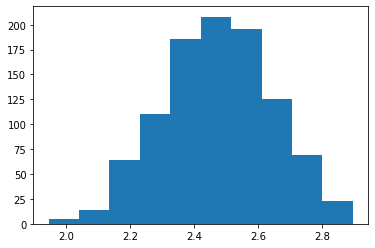

In [25]:
import matplotlib.pyplot as plt

plt.hist(values)
plt.show()

In [26]:
min(values),max(values)

(1.9442843332537878, 2.8958817020990733)

In [75]:
import math

class temperature_scheduling:
    
    def __init__(self,initial_temperature,gamma):
        self.initial_temperature=initial_temperature
        self.temperature=initial_temperature
        self.gamma=gamma
        
    def exponential_decay(self):
        self.temperature=self.gamma*self.temperature
        return self.temperature
    
    def fast_decay(self,k):
        self.temperature=self.initial_temperature/k
        return self.temperature
    
    def logarithmic_decay(self,k):
        self.temperature=self.initial_temperature*math.log(2,2)/math.log(k+1,2)
        return self.temperature

<AxesSubplot:>

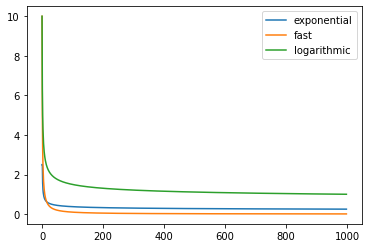

In [162]:
import pandas as pd
epochs=1000

decays={'exponential':[],'fast':[],'logarithmic':[]}

temp=temperature_scheduling(10,0.25)

for k in range(1,epochs):
    decays['exponential'].append(temp.exponential_decay())
    decays['fast'].append(temp.fast_decay(k))
    decays['logarithmic'].append(temp.logarithmic_decay(k))


pd.DataFrame(decays).plot()

In [175]:
k=0.9
initial_temperature=10*max(values)

current=np.random.permutation(list(G.nodes))
current_cycle,current_value=make_cycle(current)
temp=temperature_scheduling(initial_temperature,k)

epochs=1000000
loss=[]
for i in range(1,epochs):
    new=np.random.permutation(list(G.nodes))
    next_cycle,next_value=make_cycle(new)
    delta = (next_value-current_value)
    T=temp.exponential_decay()
    if delta>0:
        current=new
    else:
        alpha=min(1,np.exp(delta/T))
        if alpha>np.random.random():
            current=new
            current_value=next_value
    loss.append(current_value)
    

<ipython-input-175-1d524d486f94>:18: RuntimeWarning: overflow encountered in double_scalars
  alpha=min(1,np.exp(delta/T))


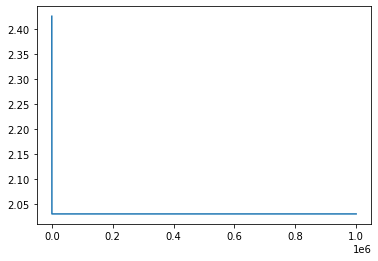

In [176]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.show()

In [172]:
current,current_value

(array(['Licantn', 'Chanco', 'Romeral', 'Longav', 'Villa Alegre', 'Retiro',
        'San Javier', 'Maule', 'Talca', 'Teno', 'Huala', 'Colbn', 'Rauco',
        'Linares', 'Sagrada Familia', 'Pencahue', 'Empedrado', 'Ro Claro',
        'Yerbas Buenas', 'Curepto', 'Cauquenes', 'Pelarco', 'San Clemente',
        'Pelluhue', 'Constitucin', 'Parral', 'Molina', 'Curic',
        'San Rafael', 'Vichuqun'], dtype='<U15'),
 1.8040034549080073)

In [173]:
current,current_value

(array(['Licantn', 'Chanco', 'Romeral', 'Longav', 'Villa Alegre', 'Retiro',
        'San Javier', 'Maule', 'Talca', 'Teno', 'Huala', 'Colbn', 'Rauco',
        'Linares', 'Sagrada Familia', 'Pencahue', 'Empedrado', 'Ro Claro',
        'Yerbas Buenas', 'Curepto', 'Cauquenes', 'Pelarco', 'San Clemente',
        'Pelluhue', 'Constitucin', 'Parral', 'Molina', 'Curic',
        'San Rafael', 'Vichuqun'], dtype='<U15'),
 1.8040034549080073)